<a href="https://colab.research.google.com/github/Gyeom-s/AI/blob/main/FTT_noise5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##데이터 증강

#### 원천 데이터 증강

In [1]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import resample

def augment_audio_with_temp(audio, sample_rate, temp_factors=(0.9, 1.0, 1.1), volume_factors=(0.8, 1.0, 1.2)):
    """
    오디오 데이터를 다양한 방식으로 증강: 속도 조정(temp), 볼륨 조절(volume), 반전(inversion).

    Parameters:
        audio (np.array): 입력 오디오 데이터.
        sample_rate (int): 샘플링 레이트.
        temp_factors (tuple): 속도 조정 비율.
        volume_factors (tuple): 볼륨 조정 비율.

    Returns:
        List[np.array]: 증강된 오디오 데이터 리스트.
    """
    augmented_audios = []

    # 속도 조정 (Time Stretching)
    for temp_factor in temp_factors:
        try:
            temp_audio = librosa.effects.time_stretch(audio, rate=temp_factor)
            resampled_audio = resample(temp_audio, len(audio))  # 원래 길이로 복구
            augmented_audios.append(resampled_audio)
        except Exception as e:
            print(f"Time stretch failed: factor={temp_factor}, error={e}")

    # 볼륨 조절 (Volume Adjustment)
    for volume_factor in volume_factors:
        volume_audio = audio * volume_factor
        volume_audio = np.clip(volume_audio, -1.0, 1.0)  # 볼륨 값 클리핑
        augmented_audios.append(volume_audio)

    # 반전 (Inversion)
    inverted_audio = -audio
    augmented_audios.append(inverted_audio)

    return augmented_audios


def augment_and_save(cry_dirs, output_dir):
    """
    오디오 데이터를 증강하고 저장.

    Parameters:
        cry_dirs (dict): 클래스별 울음소리 데이터 경로.
        output_dir (str): 증강 데이터를 저장할 경로.
    """
    os.makedirs(output_dir, exist_ok=True)

    for cry_class, cry_dir in cry_dirs.items():
        cry_files = glob.glob(os.path.join(cry_dir, '*.wav'))

        # 출력 디렉토리 생성
        class_output_dir = os.path.join(output_dir, cry_class)
        os.makedirs(class_output_dir, exist_ok=True)

        for cry_file in cry_files:
            audio, sample_rate = sf.read(cry_file)
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)  # 스테레오 → 모노 변환

            # 증강 데이터 생성
            augmented_audios = augment_audio_with_temp(audio, sample_rate)

            # 저장
            base_name = os.path.splitext(os.path.basename(cry_file))[0]
            for i, augmented_audio in enumerate(augmented_audios):
                output_path = os.path.join(class_output_dir, f"{base_name}_aug_{i}.wav")
                sf.write(output_path, augmented_audio, sample_rate)
                print(f"Saved augmented file: {output_path}")


In [3]:
cry_dirs = {
    'belly_pain': '/content/drive/MyDrive/cry_dataset/train/belly_pain',
    'burping': '/content/drive/MyDrive/cry_dataset/train/burping',
    'discomfort': '/content/drive/MyDrive/cry_dataset/train/discomfort',
    'hungry': '/content/drive/MyDrive/cry_dataset/train/hungry',
    'tired': '/content/drive/MyDrive/cry_dataset/train/tired'
}

output_dir = '/content/drive/MyDrive/cry_dataset/증강_dataset'


In [4]:
augment_and_save(cry_dirs, output_dir)


Saved augmented file: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_0.wav
Saved augmented file: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_1.wav
Saved augmented file: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_2.wav
Saved augmented file: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_3.wav
Saved augmented file: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_4.wav
Saved augmented file: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_5.wav
Saved augmented file: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-9517995637

In [6]:
import os
import glob

# 증강 데이터 저장 경로 설정
output_dir = '/content/drive/MyDrive/cry_dataset/증_dataset'

# 클래스별 데이터 개수 출력
def show_augmented_data_counts(output_dir):
    if not os.path.exists(output_dir):
        print(f"Output directory does not exist: {output_dir}")
        return

    for class_name in os.listdir(output_dir):
        class_dir = os.path.join(output_dir, class_name)
        if os.path.isdir(class_dir):  # Check if it is a directory
            file_list = glob.glob(os.path.join(class_dir, '*.wav'))
            print(f"Class: {class_name}, Total files: {len(file_list)}")
        else:
            print(f"Skipping non-directory item: {class_name}")

# 실행
show_augmented_data_counts(output_dir)


Class: belly_pain, Total files: 70
Class: burping, Total files: 49
Class: discomfort, Total files: 168
Class: hungry, Total files: 210
Class: tired, Total files: 154


#### 소음+ 울음소리 합성

In [7]:
import os
import glob
import soundfile as sf
import librosa
import numpy as np
from random import sample

def mix_with_noise(audio, noise, noise_level=0.5):
    """
    소음 데이터를 울음소리와 합성.

    Parameters:
        audio (np.array): 울음소리 데이터.
        noise (np.array): 소음 데이터.
        noise_level (float): 소음의 강도 비율 (0~1).

    Returns:
        np.array: 합성된 오디오 데이터.
    """
    min_length = min(len(audio), len(noise))
    audio = audio[:min_length]
    noise = noise[:min_length]
    mixed_audio = audio + noise_level * noise
    mixed_audio /= np.max(np.abs(mixed_audio))  # 정규화
    return mixed_audio


def augment_with_noise(input_dir, noise_dirs, output_dir, mix_ratio=0.3, noise_level=0.5):
    """
    증강된 데이터에서 30%를 소음과 합성하여 저장.

    Parameters:
        input_dir (str): 증강된 데이터 경로.
        noise_dirs (list): 소음 데이터 경로 리스트.
        output_dir (str): 합성 데이터를 저장할 경로.
        mix_ratio (float): 합성 데이터 비율 (0~1).
        noise_level (float): 소음 강도 비율 (0~1).
    """
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        # 클래스별 파일 로드
        file_list = glob.glob(os.path.join(class_input_dir, '*.wav'))
        mix_count = int(len(file_list) * mix_ratio)  # 합성 데이터 개수

        # 랜덤으로 mix_ratio 비율만큼 선택
        selected_files = sample(file_list, mix_count)

        # 소음 데이터 로드
        noise_files = []
        for noise_dir in noise_dirs:
            noise_files.extend(glob.glob(os.path.join(noise_dir, '*.wav')))

        if not noise_files:
            print("No noise files found. Please check the noise directories.")
            return

        for i, file_path in enumerate(selected_files):
            audio, sample_rate = sf.read(file_path)
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)  # 스테레오 → 모노 변환

            # 랜덤한 소음 파일 선택
            noise_file = sample(noise_files, 1)[0]
            noise_audio, noise_sample_rate = sf.read(noise_file)

            if len(noise_audio.shape) > 1:
                noise_audio = np.mean(noise_audio, axis=1)

            # 샘플 레이트 맞추기
            if sample_rate != noise_sample_rate:
                noise_audio = librosa.resample(noise_audio, orig_sr=noise_sample_rate, target_sr=sample_rate)

            # 합성
            mixed_audio = mix_with_noise(audio, noise_audio, noise_level)

            # 저장
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            output_path = os.path.join(class_output_dir, f"{base_name}_mix_{i}.wav")
            sf.write(output_path, mixed_audio, sample_rate)
            print(f"Saved mixed file: {output_path}")


In [8]:
# 증강된 데이터 경로
input_dir = '/content/drive/MyDrive/cry_dataset/증_dataset'

# 소음 데이터 경로 리스트
noise_dirs = [
    '/content/drive/MyDrive/noise/child',
    '/content/drive/MyDrive/noise/adult',
    '/content/drive/MyDrive/noise/cleaner',
    '/content/drive/MyDrive/noise/dog',
    '/content/drive/MyDrive/noise/cat'
]

# 합성 데이터 저장 경로
output_dir = '/content/drive/MyDrive/cry_dataset/합성_dataset'

# 합성 실행
augment_with_noise(input_dir, noise_dirs, output_dir, mix_ratio=0.3, noise_level=0.5)


Saved mixed file: /content/drive/MyDrive/cry_dataset/합성_dataset/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp_aug_4_mix_0.wav
Saved mixed file: /content/drive/MyDrive/cry_dataset/합성_dataset/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138647-1.0-m-72-bp_aug_2_mix_1.wav
Saved mixed file: /content/drive/MyDrive/cry_dataset/합성_dataset/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp_aug_0_mix_2.wav
Saved mixed file: /content/drive/MyDrive/cry_dataset/합성_dataset/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138524-1.0-m-72-bp_aug_2_mix_3.wav
Saved mixed file: /content/drive/MyDrive/cry_dataset/합성_dataset/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138524-1.0-m-72-bp_aug_6_mix_4.wav
Saved mixed file: /content/drive/MyDrive/cry_dataset/합성_dataset/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138545-1.0-m-72-bp_aug_6_mix_5.wav
Saved mixed file: /content/drive/MyDrive/cry_dataset/합성_dataset/belly_pain/643D64AD-B711-469A-

#### 증강 데이터+ 합성 데이터=> 병합


In [20]:
import os
import shutil
import glob

def merge_datasets_unconditionally(source_dirs, target_dir):
    """
    두 개 이상의 데이터셋을 병합하여 하나의 병합 데이터셋 생성.

    Parameters:
        source_dirs (list): 소스 데이터 디렉토리 리스트 (증_dataset 및 합성_dataset 경로).
        target_dir (str): 병합된 데이터를 저장할 타겟 디렉토리.
    """
    os.makedirs(target_dir, exist_ok=True)

    for source_dir in source_dirs:
        if not os.path.exists(source_dir):
            print(f"Source directory does not exist: {source_dir}")
            continue

        for class_name in os.listdir(source_dir):
            class_source_dir = os.path.join(source_dir, class_name)
            class_target_dir = os.path.join(target_dir, class_name)
            os.makedirs(class_target_dir, exist_ok=True)

            if os.path.isdir(class_source_dir):
                # 모든 파일을 타겟 디렉토리로 복사
                for file_path in glob.glob(os.path.join(class_source_dir, '*.wav')):
                    try:
                        target_file = os.path.join(class_target_dir, os.path.basename(file_path))
                        shutil.copy2(file_path, target_file)
                        print(f"Copied: {file_path} -> {target_file}")
                    except Exception as e:
                        print(f"Error copying {file_path}: {e}")


In [23]:
# 소스 데이터 경로
source_dirs = [
    '/content/drive/MyDrive/cry_dataset/증_dataset',
    '/content/drive/MyDrive/cry_dataset/합성_dataset'
]

# 병합 데이터 저장 경로
target_dir = '/content/drive/MyDrive/cry_dataset/병합_dataset'

# 병합 실행
merge_datasets_unconditionally(source_dirs, target_dir)


Copied: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_0.wav -> /content/drive/MyDrive/cry_dataset/병합_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_0.wav
Copied: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_1.wav -> /content/drive/MyDrive/cry_dataset/병합_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_1.wav
Copied: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_2.wav -> /content/drive/MyDrive/cry_dataset/병합_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_2.wav
Copied: /content/drive/MyDrive/cry_dataset/증_dataset/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_aug_3.wav -> /content/drive/MyDrive/cry_dataset/병합_dataset/belly_pain/69BDA5D6-0276-

In [24]:
for class_name in os.listdir(target_dir):
    class_dir = os.path.join(target_dir, class_name)
    if os.path.isdir(class_dir):
        file_list = glob.glob(os.path.join(class_dir, '*.wav'))
        print(f"Class: {class_name}, Total files: {len(file_list)}")


Class: belly_pain, Total files: 91
Class: burping, Total files: 63
Class: discomfort, Total files: 218
Class: hungry, Total files: 273
Class: tired, Total files: 200


## 데이터 전처리

In [ ]:
#필요한 라이브러리
import os
import glob
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation


In [25]:

# FFT 스펙트로그램 생성 함수
def compute_fft_spectrogram(audio, sample_rate, window_size, step_size):
    nperseg = int(window_size * sample_rate / 1000)  # 윈도우 크기 (샘플 단위)
    noverlap = nperseg - int(step_size * sample_rate / 1000)  # 오버랩 크기

    frequencies, times, spectrogram = scipy.signal.spectrogram(
        audio,
        fs=sample_rate,
        nperseg=nperseg,
        noverlap=noverlap,
        mode='magnitude'
    )

    return spectrogram

# 데이터 로드 및 FFT 스펙트로그램 생성
def load_fft_data(input_dirs, window_size=20, step_size=10, target_shape=(128, 128)):
    """
    모든 클래스의 FFT 스펙트로그램 데이터 생성 및 저장.

    Parameters:
        input_dirs (dict): 클래스별 데이터 경로.
        window_size (int): FFT 윈도우 크기 (ms).
        step_size (int): FFT 스텝 크기 (ms).
        target_shape (tuple): 출력 스펙트로그램 크기 (128x128).

    Returns:
        tuple: (X 데이터 배열, y 레이블 배열)
    """
    X, y = [], []
    class_labels = {class_name: idx for idx, class_name in enumerate(input_dirs.keys())}

    for class_name, dir_path in input_dirs.items():
        print(f"Processing class: {class_name}")
        file_list = glob.glob(os.path.join(dir_path, '*.wav'))

        for file_path in file_list:
            try:
                # 오디오 파일 읽기
                audio, sample_rate = sf.read(file_path)
                if len(audio.shape) > 1:
                    audio = np.mean(audio, axis=1)  # 스테레오 -> 모노 변환

                # FFT 스펙트로그램 생성
                spectrogram = compute_fft_spectrogram(audio, sample_rate, window_size, step_size)

                # 크기 조정 (128x128으로 리사이즈)
                spectrogram_resized = scipy.ndimage.zoom(spectrogram, (target_shape[0]/spectrogram.shape[0],
                                                                       target_shape[1]/spectrogram.shape[1]))

                # 정규화
                spectrogram_normalized = spectrogram_resized / np.max(spectrogram_resized)

                # 데이터 저장
                X.append(spectrogram_normalized)
                y.append(class_labels[class_name])

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    X = np.array(X)
    y = np.array(y)
    return X, y

# 증강된 데이터 경로 설정
input_dirs = {
    'belly_pain': '/content/drive/MyDrive/cry_dataset/병합_dataset/belly_pain',
    'burping': '/content/drive/MyDrive/cry_dataset/병합_dataset/burping',
    'discomfort': '/content/drive/MyDrive/cry_dataset/병합_dataset/discomfort',
    'hungry': '/content/drive/MyDrive/cry_dataset/병합_dataset/hungry',
    'tired': '/content/drive/MyDrive/cry_dataset/병합_dataset/tired'
}


# 데이터 로드
X, y = load_fft_data(input_dirs)

# 데이터 전처리
X = X[..., np.newaxis]  # CNN 입력에 맞게 채널 추가 (128, 128) -> (128, 128, 1)
y = to_categorical(y, num_classes=len(input_dirs))  # 클래스 레이블 원-핫 인코딩

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




Processing class: belly_pain
Processing class: burping
Processing class: discomfort
Processing class: hungry
Processing class: tired


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 652ms/step - accuracy: 0.3041 - loss: 1.5401 - val_accuracy: 0.3373 - val_loss: 1.4344
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 451ms/step - accuracy: 0.4078 - loss: 1.3990 - val_accuracy: 0.6036 - val_loss: 1.1942
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.5569 - loss: 1.1526 - val_accuracy: 0.6805 - val_loss: 0.8874
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.6907 - loss: 0.8626 - val_accuracy: 0.8402 - val_loss: 0.5214
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - accuracy: 0.8092 - loss: 0.5916 - val_accuracy: 0.9467 - val_loss: 0.3212
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - accuracy: 0.8722 - loss: 0.3816 - val_accuracy: 0.9467 - val_loss: 0.2244
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step - accuracy: 0.9045 - loss: 0.2652 - val_accuracy: 0.9586 - val_loss: 0.1817
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.9179 - loss: 0.2080 - val_accuracy

## CNN 모델

In [ ]:
# CNN 모델 생성
def create_cnn_model(input_shape=(128, 128, 1), num_classes=6):
    model = Sequential()
    model.add(Conv2D(filters=24, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model



## 모델 학습

In [ ]:
# 모델 생성
cnn_model = create_cnn_model(input_shape=X.shape[1:], num_classes=len(input_dirs))

# 모델 컴파일
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 학습
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


##테스트 결과

In [ ]:

# 테스트 데이터 평가
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

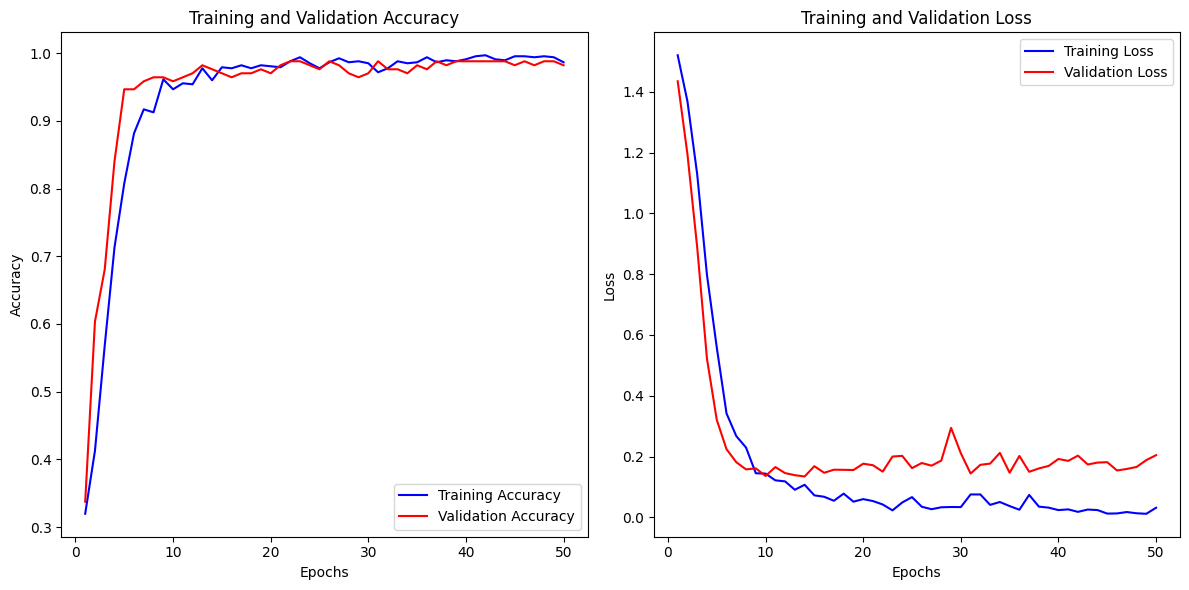

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    학습 과정의 정확도와 손실을 시각화합니다.

    Parameters:
        history (History): 모델 학습 결과를 포함한 History 객체.
    """
    # 학습 정확도와 검증 정확도
    acc = history.history['accu
    racy']
    val_acc = history.history['val_accuracy']

    # 학습 손실과 검증 손실
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # 정확도 그래프
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 그래프 보여주기
    plt.tight_layout()
    plt.show()

# 학습 결과 시각화
plot_training_history(history)


## 모델 저장

In [27]:
# 모델 저장 디렉토리 설정
model_save_path = '/content/drive/MyDrive/cry_dataset/cnn_model.h5'

# 모델 저장
cnn_model.save(model_save_path)
print(f"Model saved at {model_save_path}")


Model saved at /content/drive/MyDrive/cry_dataset/cnn_model.h5
